In [89]:
import numpy as np
from matplotlib import pyplot as plt
verbosity = False

# Utils

def inverse_sigmoid(var):
    '''
    return 1/(1+exp(var))
    avoid large overflow
    '''
    if var>=0:
        return np.exp(-var)/(1+np.exp(-var))
    else:
        return 1/(1+np.exp(var))

def init_weights(m):
    '''
    Generate random weights in [0,1]
    '''
    return np.random.rand(m, 1)

def logistic_loss_vectorized(w, X, y, la):
    '''
    input: w parameter, X variables, y label, la lambda
    Assignment 6.1
    return f as the loss function value and g as the gradient
    '''
    x_mul_w = np.matmul(X, w)
    y_X_w = np.multiply(y, x_mul_w)
    f = np.sum(np.logaddexp(0, -y_X_w)) + la * np.sum(np.multiply(w,w))
    inv_sigmoid_vector = np.exp(np.minimum(0, -y_X_w))/(1 + np.exp(np.multiply(-y_X_w,np.sign(y_X_w)))) # n * 1
    y_inv_sigmoid = -1 * np.multiply(y, inv_sigmoid_vector)
    g =  np.matmul(y_inv_sigmoid.reshape(1,-1),X) + 2 * la * w.reshape(1,-1)
    g = g.reshape(-1, 1)
    return (f, g)

def hinge_loss_vectorized(w, X, y, la):
    '''
    input: w parameter, X variables, y label, la lambda
    Assignment 6.2
    return f as the loss function value and g as the gradient
    '''
    n = X.shape[0]
    X_cdot_w = np.matmul(X, w)
    one_minus = 1 - np.multiply(X_cdot_w, y)
    f = np.sum(np.maximum(0, one_minus)) + la * np.sum(np.multiply(w,w))
    minus_y = -1 * np.multiply(y, np.double(one_minus>0))
    g = np.matmul(minus_y.reshape(1,-1),X).reshape(-1,1)  + 2 * la *w.reshape(-1,1)
    g = g.reshape(-1,1)
    return (f, g)

def plot(losses, labels):
    fig,ax = plt.subplots()
    for i in range(len(losses)):
        ax.plot(range(1,len(losses[i])+1), losses[i], label=labels[i])
    ax.legend()
    ax.set_xlabel("# Iterations")
    ax.set_ylabel("Loss Function Value")

# Question 7

## Load data

In [6]:
'''
Copied from https://github.com/rishabhk108/OptimizationML/tree/master/Assignments/data/README.md
'''

from scipy.io import loadmat
import numpy as np
def load_data():
    X = loadmat(r"train.mat")
    y = np.loadtxt(r"train.targets").reshape(-1, 1)
    X = X['X'].todense()
    # print(X.shape)
    # print(y.shape)
    return X,y

## Run the vectorized version of Logistic_Loss function and Hinge/SVMs_Loss function

In [7]:
def test_loss_functions():
    X,y = load_data()
    m = X.shape[1]
    w = init_weights(m)
    la = 1.0
    print('''### Logistic Loss ###''')
    f,g = logistic_loss_vectorized(w, X, y, la)
    print('''Loss Func Value: '''),
    print(f)
    print('''Gradient: ''')
    print(g.reshape(1,-1))
    print('''### Hinge/SVMs Loss ###''')
    f,g = hinge_loss_vectorized(w, X, y, la)
    print('''Loss Func Value: '''),
    print(f)
    print('''Gradient: ''')
    print(g.reshape(1,-1))

test_loss_functions()

### Logistic Loss ###
Loss Func Value:  2892070.440933672
Gradient: 
[[1053.57646891  636.5018289    69.59184617 ... 1162.83425401
   312.62138932  416.92579371]]
### Hinge/SVMs Loss ###
Loss Func Value:  2904296.440933672
Gradient: 
[[1053.57646891  636.5018289    69.59184617 ... 1162.83425401
   312.62138932  416.92579371]]


## Gradient Descent with Fixed Learning rate alpha = 1e-05

In [11]:
def gradient_descent_fixed_eta(func_obj,w, max_iter, alpha, X, y, la):
    f,g = func_obj(w,X,y,la)
    loss = []
    for cur_iter in range(1, max_iter+1):
        f,g = func_obj(w,X,y,la)
        loss.append(f)
        if verbosity:
            print("Iteration: " + str(cur_iter) + ", alpha = " + str(alpha) +
              ", Loss Function Value = " + str(f))
        w = w - alpha * g
    return loss

## Test Block for Gradient Descent with Fixed Learning rate

### Gradient Descent with Fixed Learning rate alpha = 1e-05 ###
## Logistic Loss ##
### Gradient Descent with Fixed Learning rate alpha = 1e-05 ###
## Hinge Loss ##


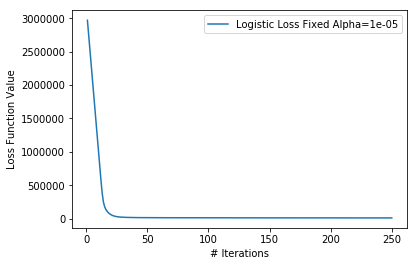

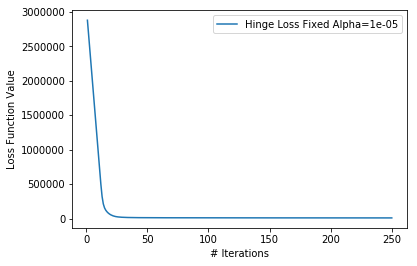

In [20]:
def test_gradient_descent_fixed_eta():

    X,y = load_data()
    m = X.shape[1]
    w = init_weights(m)
    
    logistic_loss = gradient_descent_fixed_eta(logistic_loss_vectorized, w, 250, 0.00001, X, y, 1.0)
    w = init_weights(m)
    print('''### Gradient Descent with Fixed Learning rate alpha = 1e-05 ###''')
    print('''## Hinge Loss ##''')
    hinge_loss = gradient_descent_fixed_eta(hinge_loss_vectorized, w, 250, 0.00001, X, y, 1.0)
    print('''### Gradient Descent with Fixed Learning rate alpha = 1e-05 ###''')
    print('''## Logistic Loss ##''')
    plot([logistic_loss,],['''Logistic Loss Fixed Alpha=1e-05''',])
    plot([hinge_loss,],['''Hinge Loss Fixed Alpha=1e-05''',])
    return [logistic_loss, hinge_loss], '''Fixed Alpha=1e-05'''
    
func1_res, func1_label = test_gradient_descent_fixed_eta()

## Gradient Descent with Armijo Line Search (v4) gamma=1e-04

In [25]:
from numpy import linalg as LA

def gradient_descent_Armijo_v4(func_obj, w, max_iter, alpha, X, y, la, gamma):
    f,g = func_obj(w,X,y,la)
    pre_f = f # last iteration loss
    pre_g = g # last iteration gradient
    alpha = alpha / LA.norm(g, 1) # heuristic alpha
    loss = []
    cur_iter = 1
    while cur_iter<=max_iter:
        w_tent = w - alpha * g
        f_tent, g_tent = func_obj(w_tent, X, y, la)
        loss.append(f)
        cur_iter+=1
        gTg=np.dot(g.T, g)[0,0]
        while f_tent > f - alpha * gamma* gTg: # Armijo condition f(w-ag) \le f(w) - alpha * gamma * ||g||^2
            alpha = alpha*alpha*gTg /(2*(f_tent + alpha* gTg - f))  # Armijo v3 interpolation
            w_tent = w - alpha * g
            f_tent, g_tent = func_obj(w_tent, X, y, la)
            loss.append(f)
            cur_iter+=1
        if cur_iter>1:
            alpha = min(1, 2 * (pre_f - f)/gTg)
        if verbosity:
            print("Iteration: " + str(cur_iter) + ", alpha = " + str(alpha) +
              ", Loss Function Value = " + str(f_tent))
        pre_f = f
        pre_g = g
        f = f_tent
        g = g_tent
        w = w_tent
    return loss



### Gradient Descent with Armijo Line Search (v4) gamma = 1e-04 ###
## Logistic Loss ##
### Gradient Descent with Armijo Line Search (v4) gamma = 1e-04 ###
## Hinge Loss ##


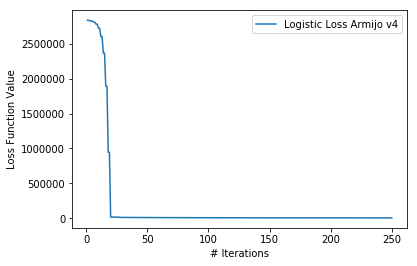

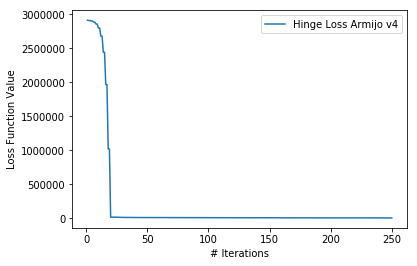

In [26]:
def test_gradient_descent_Armijo_v4():
    
    X,y = load_data()
    m = X.shape[1]
    w = init_weights(m)
    print('''### Gradient Descent with Armijo Line Search (v4) gamma = 1e-04 ###''')
    print('''## Logistic Loss ##''')
    logistic_loss = gradient_descent_Armijo_v4(logistic_loss_vectorized, w, 250, 1, X, y, 1.0, 0.0001)
    w = init_weights(m)
    print('''### Gradient Descent with Armijo Line Search (v4) gamma = 1e-04 ###''')
    print('''## Hinge Loss ##''')
    hinge_loss=gradient_descent_Armijo_v4(hinge_loss_vectorized, w, 250, 1, X, y, 1.0, 0.0001)
    plot([logistic_loss,],['''Logistic Loss Armijo v4''',])
    plot([hinge_loss,],['''Hinge Loss Armijo v4''',])
    return [logistic_loss, hinge_loss], '''Armijo v4'''
    
func2_res, func2_label = test_gradient_descent_Armijo_v4()

## Accelerated Gradient Descent

In [43]:
from numpy import linalg as LA

def accelerated_gradient_descent(func_obj, w, max_iter, alpha, X, y, gamma, la):
    f,g = func_obj(w,X,y,la)
    pre_f = f # last iteration loss
    pre_g = g # last iteration gradient
    # alpha = alpha / LA.norm(g, 1) # heuristic alpha
    w_y = w
    loss = [f, ]
    la_t = 0.0
    for cur_iter in range(1, max_iter+1):
        new_la_t = (1.0+np.sqrt(4*la_t*la_t))/2
        gamma_t = (1-la_t)/new_la_t
        new_w_y = w - alpha * g
        w = (1-gamma_t)*new_w_y + gamma_t * w_y
        f, g = func_obj(w, X, y, la)
        la_t = new_la_t
        w_y = new_w_y
        loss.append(f)
        if verbosity:
            print("Iteration: " + str(cur_iter) + ", alpha = " + str(alpha) + 
              ", Loss Function Value = " + str(f))
    return loss

def accelerated_gradient_descent_line_search(func_obj, w, max_iter, alpha, X, y, gamma, la):
    f,g = func_obj(w,X,y,la)
    loss = [f, ]
    # alpha = alpha / LA.norm(g, 1) # heuristic alpha
    w_y = w
    new_w_y = w
    la_t = 0.0
    cur_iter = 1
    while cur_iter <= max_iter:
        if cur_iter>1:
            new_la_t = (1.0+np.sqrt(4*la_t*la_t))/2
            gamma_t = (1-la_t)/new_la_t
            w = w_y + ((la_t-1)/new_la_t)*(new_w_y - w_y)
            la_t = new_la_t
            f, g = func_obj(w, X, y, la)
            cur_iter += 1
        w_y = new_w_y
        w_tent = w - alpha * g
        f_tent, g_tent = func_obj(w_tent, X, y, la)
        cur_iter+=1
        gTg=np.dot(g.T, g)[0,0]
        backtracking = False
        while f_tent > f - alpha * gamma* gTg: # Armijo condition f(w-ag) \le f(w) - alpha * gamma * ||g||^2
            alpha = alpha*alpha*gTg /(2*(f_tent + alpha* gTg - f))  # Armijo v3 interpolation
            w_tent = w - alpha * g
            f_tent, g_tent = func_obj(w_tent, X, y, la)
            if f<loss[-1]:
                loss.append(f)
            else:
                loss.append(loss[-1])
            cur_iter+=1
            backtracking = True
        new_w_y = w_tent
        f = f_tent
        g = g_tent
        if not backtracking:
            if f<loss[-1]:
                loss.append(f)
            else:
                loss.append(loss[-1])
        if verbosity:
            print("Iteration: " + str(cur_iter) + ", alpha = " + str(alpha) + 
              ", Loss Function Value = " + str(f))
    return loss

### Accelerated gradient descent ###
## Logistic Loss ##
### Accelerated gradient descent ###
## Hinge Loss ##
### Accelerated gradient descent ###
## Logistic Loss ##
### Accelerated gradient descent ###
## Hinge Loss ##


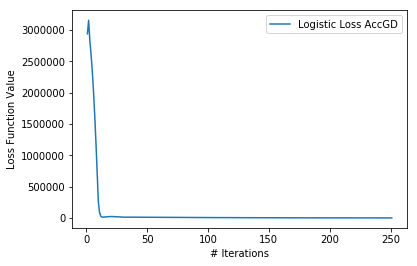

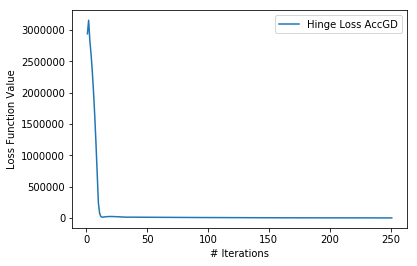

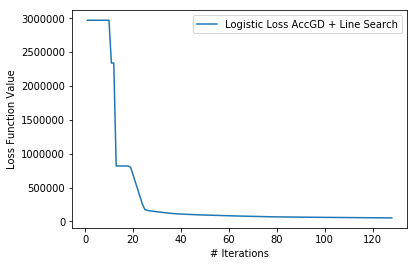

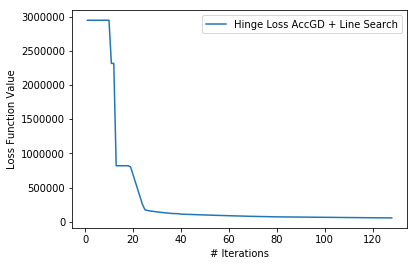

In [47]:
def test_accelerated_gradient_descent():
    
    X,y = load_data()
    m = X.shape[1]
    w = init_weights(m)
    print('''### Accelerated gradient descent ###''')
    print('''## Logistic Loss ##''')
    logistic_loss = accelerated_gradient_descent(logistic_loss_vectorized, w, 250, 0.00001, X, y, 0.0001, 1.0)
    w = init_weights(m)
    print('''### Accelerated gradient descent ###''')
    print('''## Hinge Loss ##''')
    hinge_loss = accelerated_gradient_descent(hinge_loss_vectorized, w, 250, 0.00001, X, y, 0.0001, 1.0)
    plot([logistic_loss,],['''Logistic Loss AccGD''',])
    plot([hinge_loss,],['''Hinge Loss AccGD''',])
    return [logistic_loss, hinge_loss], '''AccGD'''

def test_accelerated_gradient_descent_line_search():
    
    X,y = load_data()
    m = X.shape[1]
    w = init_weights(m)
    print('''### Accelerated gradient descent ###''')
    print('''## Logistic Loss ##''')
    logistic_loss = accelerated_gradient_descent_line_search(logistic_loss_vectorized, w, 250, 1, X, y, 0.0001, 1.0)
    w = init_weights(m)
    print('''### Accelerated gradient descent ###''')
    print('''## Hinge Loss ##''')
    hinge_loss = accelerated_gradient_descent_line_search(hinge_loss_vectorized, w, 250, 1, X, y, 0.0001, 1.0)
    plot([logistic_loss,],['''Logistic Loss AccGD + Line Search''',])
    plot([hinge_loss,],['''Hinge Loss AccGD + Line Search''',])
    return [logistic_loss, hinge_loss], '''AccGD + Line Search'''
    
func3_res, func3_label = test_accelerated_gradient_descent()
_,_  = test_accelerated_gradient_descent_line_search()

## Conjugate Gradient (Flether-Reeves)

In [55]:
from numpy import linalg as LA

# verbosity = True

def conjugate_gradient_descent(func_obj, w, max_iter, alpha, X, y, la, gamma):
    f,g = func_obj(w,X,y,la)
    pre_f = f
    pre_g = g
    pre_d = -pre_g # d_k
    beta= 1.0
    loss = []
    alpha = alpha / LA.norm(g, 1) # heuristic alpha
    cur_iter = 1
    while cur_iter<=max_iter:
        w_tent = w + alpha * pre_d # x_{k+1} = x_k + alpha * d_k
        f_tent, g_tent = func_obj(w_tent, X, y, la)
        gTg = np.dot(g.T, g)[0,0]
        loss.append(f)
        cur_iter += 1
        while f_tent > f - alpha * gamma * gTg:
            alpha = alpha * alpha * gTg / (2*(f_tent + alpha* gTg - f))
            w_tent = w + alpha * pre_d
            f_tent, g_tent = func_obj(w_tent, X, y, la)
            loss.append(f)
            cur_iter += 1
        if verbosity:
            print("Iteration: " + str(cur_iter) + ", alpha = " + str(alpha) +
              ", Loss Function Value = " + str(f_tent))
        if cur_iter>1:
            alpha = min(1, 2 * (pre_f - f)/gTg)
        beta = np.dot(g_tent.T, g)[0,0]/np.dot(pre_g.T, pre_g)[0,0]
        d = -g_tent + beta * pre_d
        pre_d = d
        pre_g = g
        pre_f = f
        f = f_tent
        g = g_tent
        w = w_tent
    return loss

### conjugate gradient descent ###
## Logistic Loss ##
### conjugate gradient descent ###
## hinge Loss ##


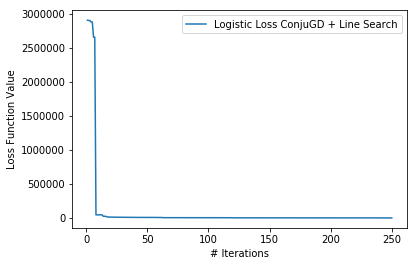

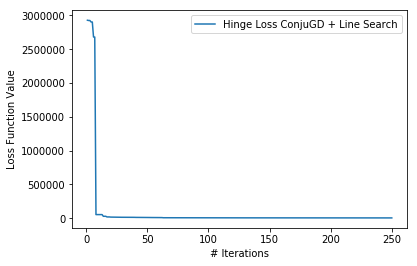

In [56]:
def test_conjugate_gradient_descent():
    
    X,y = load_data()
    m = X.shape[1]
    w = init_weights(m)
    print('''### conjugate gradient descent ###''')
    print('''## Logistic Loss ##''')
    logistic_loss = conjugate_gradient_descent(logistic_loss_vectorized, w, 250, 1, X, y, 1.0, 0.0001)
    w = init_weights(m)
    print('''### conjugate gradient descent ###''')
    print('''## hinge Loss ##''')
    hinge_loss = conjugate_gradient_descent(hinge_loss_vectorized, w, 250, 1, X, y, 1.0, 0.0001)
    plot([logistic_loss,],['''Logistic Loss ConjuGD + Line Search''',])
    plot([hinge_loss,],['''Hinge Loss ConjuGD + Line Search''',])
    return [logistic_loss, hinge_loss], '''ConjuGD + Line Search'''

func4_res, func4_label = test_conjugate_gradient_descent()

## Barzelia-Borwein step Gradient Descent (Approach 2)

In [85]:
from numpy import linalg as LA
verbosity=True
def Barzelia_Borwein_step_gradient_descent(func_obj, w, max_iter, alpha, X, y, la, gamma):
    verbosity=False
    f,g = func_obj(w,X,y,la)
    x = w
    loss = []
    cur_iter = 1
    alpha = alpha / LA.norm(g, 1) # heuristic alpha
    while cur_iter<=max_iter:
        x_tent = x - alpha * g
        f_tent, g_tent = func_obj(x_tent, X, y, la)
        loss.append(f)
        cur_iter+=1
        gTg=np.dot(g.T, g)[0,0]
        while f_tent > f - alpha * gamma* gTg: # Armijo condition f(w-ag) \le f(w) - alpha * gamma * ||g||^2
            alpha = alpha*alpha*gTg /(2*(f_tent + alpha* gTg - f))  # Armijo v3 interpolation
            x_tent = x - alpha * g
            f_tent, g_tent = func_obj(x_tent, X, y, la)
            loss.append(f)
            cur_iter+=1
        y_k = g_tent - g
        alpha = -alpha * np.dot(g.T, y_k)[0,0]/np.dot(y_k.T, y_k)[0,0]
        x = x_tent
        f = f_tent
        g = g_tent
        if verbosity:
            print("Iteration: " + str(cur_iter) + ", alpha = " + str(alpha) +
                  ", Loss Function Value = " + str(f))
    return loss


### Barzelia_Borwein_step gradient descent ###
## Logistic Loss ##
### Barzelia_Borwein_step gradient descent ###
## Hinge Loss ##


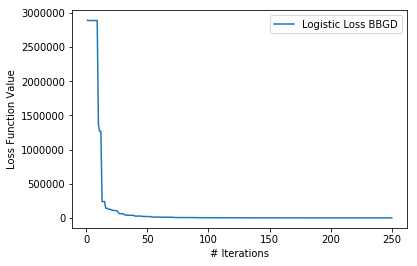

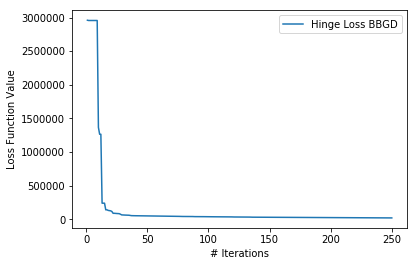

In [86]:
def test_Barzelia_Borwein_step_gradient_descent():
    X,y = load_data()
    m = X.shape[1]
    w = init_weights(m)
    print('''### Barzelia_Borwein_step gradient descent ###''')
    print('''## Logistic Loss ##''') 
    logistic_loss = Barzelia_Borwein_step_gradient_descent(logistic_loss_vectorized, w, 250, 1, X, y, 1.0, 1e-04)
    print('''### Barzelia_Borwein_step gradient descent ###''')
    print('''## Hinge Loss ##''') 
    w = init_weights(m)
    hinge_loss = Barzelia_Borwein_step_gradient_descent(hinge_loss_vectorized, w, 250, 1, X, y, 1.0, 1e-04)
    plot([logistic_loss,],['''Logistic Loss BBGD''',])
    plot([hinge_loss,],['''Hinge Loss BBGD''',])
    return [logistic_loss, hinge_loss], '''BBGD'''

func5_res, func5_label = test_Barzelia_Borwein_step_gradient_descent()

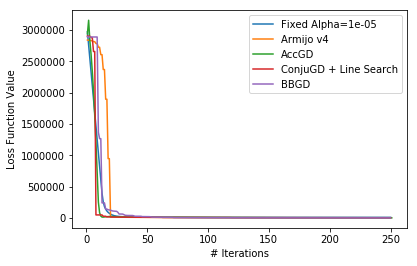

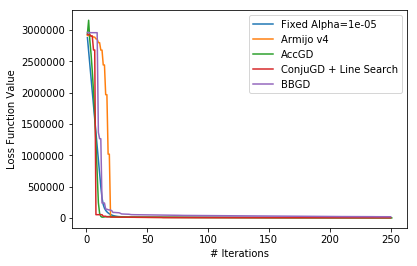

In [87]:
# Put all together
losses = [func1_res, func2_res, func3_res, func4_res, func5_res]
labels = [func1_label, func2_label, func3_label, func4_label, func5_label]
plot([e[0] for e in losses], labels)
plot([e[1] for e in losses], labels)

### LBFGS ###
## Logistic Loss ##
### LBFGS ###
## Hinge Loss ##


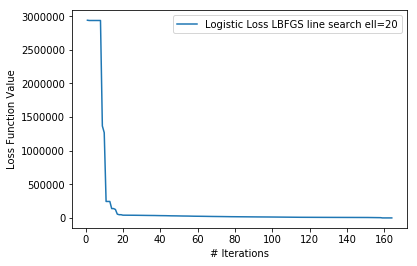

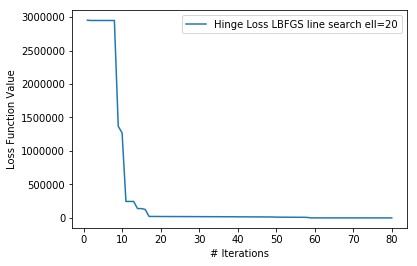

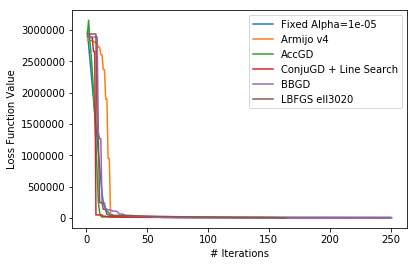

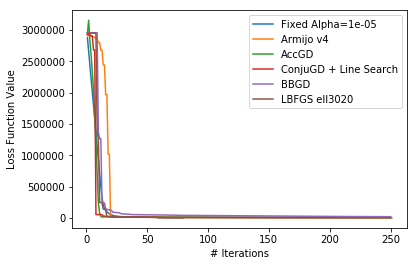

In [90]:
import collections

def LBFGS_direction(g_k, S_ell, Y_ell, h):
    '''
    return the gradient descent direction of next step
    s_k = w_{k+1} - w_k
    y_k = g_{k+1} - g_k
    p_k = 1/(y_k^T.s_k)
    H_k = (B_k)^{-1} (inverse of B_k)
    H_{k+1} = (I - s_k.y_k^T)/s_k^T.y_{k}) H_k (I - y_k.s_k^T)/y_k^T.s_k) + s_k.s_k^T/y_k^T.s_k
            = (I - p_k.s_k.y_k^T}) H_k (I - p_k.y_k.s_k^T) + p_k.s_k.s_k^T
    Assuming H_{k}=I
    q_k = g_k
    q_i = (I - p_i.y_i.s_i^T) * q_{i+1}
    a_i = p_i.s_i^T * q_{i+1}
    then q_i = q_{i+1} - a_i.y_i
    beta_i = p_i.y_i^T.z_i
    z_i = H_i.q_i
    '''
    q = g_k
    p = np.zeros(len(S_ell))
    a = np.zeros(len(S_ell))
    Q1 = g_k
    for i in range(len(S_ell)-1, -1, -1):
        p[i] = 1/np.dot(Y_ell[i].T, S_ell[i])[0,0] # p_i = 1/(y_i^T.s_i) # ro ?
        a[i] = p[i] * np.dot(S_ell[i].T, q)[0,0] # a_i = p_i.s_i^T * q_{i+1}
        if i == 0:
            Q1 = q
        q = q - a[i] * Y_ell[i] # q_i = q_{i+1} - a_i.y_i
    # gamma_k = s_{k-1}^T.y_{k-1}/ y_{k-1}^T.y_{k-1} # approximation
    # gamma_k = np.dot(S_ell[-1].T, Y_ell[-1])[0,0]/np.dot(Y_ell[-1].T, Y_ell[-1])[0,0]
    # H_{k-l} = gamma_k * I
    # H_k_0 = gamma_k * np.identity(q.shape[0])
    z = h * Q1
    for i in range(len(S_ell)):
        beta_i = p[i] * np.dot(Y_ell[i].T, z)[0,0] 
        z = z + S_ell[i] * (a[i]-beta_i) # z_{i+1} = z_i + (a_i - beta_i)s_i
    return -z # alpha * -z = s_k

def LBFGS(func_obj, w, max_iter, alpha, X, y, la, gamma, ell):
    f, g = func_obj(w, X, y, la)
    S_ell = collections.deque()
    Y_ell = collections.deque()
    # alpha = alpha / LA.norm(g, 1) # initialize of alpha
    z = -g
    pre_w = w
    pre_f = f
    pre_g = g
    loss = [f, ]
    for cur_iter in range(1, max_iter+1):
        w_tent = w + alpha * z
        f_tent, g_tent = func_obj(w_tent, X, y, la)
        s_k = w_tent - w
        y_k = g_tent - g
        S_ell.append(s_k)
        Y_ell.append(y_k)
        if len(S_ell)>ell:
            S_ell.popleft()
            Y_ell.popleft()
        h = alpha*(np.dot(z.T, Y_ell[-1])[0,0])/(np.dot(Y_ell[-1].T, Y_ell[-1])[0,0]);
        z = LBFGS_direction(g_tent, S_ell, Y_ell, h)
        if verbosity:
            print("Iteration: " + str(cur_iter) + ", alpha = " + str(alpha) +
              ", Loss Function Value = " + str(f_tent))
        pre_f = f
        pre_g = g
        w = w_tent
        g = g_tent
        f = f_tent
        loss.append(f)
    return loss

def LBFGS_line_search(func_obj, w, max_iter, alpha, X, y, la, gamma, ell):
    # verbosity=True
    x = w # x
    f, g = func_obj(x, X, y, la)
    S_ell = collections.deque()
    Y_ell = collections.deque()
    loss = [f,]
    alpha = alpha / LA.norm(g, 1) # initialize of alpha
    z = -g
    cur_iter = 1
    while cur_iter<=max_iter:
        x_tent = x + alpha * z
        f_tent, g_tent = func_obj(x_tent, X, y, la)
        gd = np.dot(g.T, -z)[0,0]
        cur_iter += 1
        backtracking = False
        while f_tent > f - alpha * gamma* gd: # Armijo condition f(w-ag) \le f(w) - alpha * gamma * ||g||^2
            alpha = alpha*alpha*gd /(2*(f_tent + alpha* gd - f))  # Armijo v3 interpolation
            x_tent = x + alpha * z
            loss.append(f)
            f_tent, g_tent = func_obj(x_tent, X, y, la)
            cur_iter += 1
            backtracking = True
        s_k = x_tent - x
        y_k = g_tent - g
        S_ell.append(s_k)
        Y_ell.append(y_k)
        if len(S_ell)>ell:
            S_ell.popleft()
            Y_ell.popleft()
        if verbosity:
            print("Iteration: " + str(cur_iter) + ", alpha = " + str(alpha) +
              ", Loss Function Value = " + str(f_tent))
        h = alpha*(np.dot(z.T, Y_ell[-1])[0,0])/(np.dot(Y_ell[-1].T, Y_ell[-1])[0,0]);
        x = x_tent
        g = g_tent
        f = f_tent
        z = LBFGS_direction(g_tent, S_ell, Y_ell, h)
        if backtracking:
            loss.append(f)
        alpha = 1
    return loss

def test_LBFGS(ell):
    '''
    ell is how many previous step we store
    '''
    X,y = load_data()
    w = init_weights(X.shape[1])
    print('''### LBFGS ###''')
    print('''## Logistic Loss ##''')
    logistic_loss = LBFGS(logistic_loss_vectorized, w, 250, 1e-05, X, y, 1.0, 0.0001, ell)
    print('''### LBFGS ###''')
    print('''## Hinge Loss ##''')
    hinge_loss = LBFGS(hinge_loss_vectorized, w, 250, 1e-05, X, y, 1.0, 0.0001, ell)
    plot([logistic_loss,],['''Logistic Loss LBFGS ell='''+str(ell),])
    plot([hinge_loss,],['''Hinge Loss LBFGS ell='''+str(ell),])
    return [logistic_loss, hinge_loss], '''LBFGS ell30'''+str(ell)
    
def test_LBFGS_line_search(ell):
    '''
    ell is how many previous step we store
    '''
    X,y = load_data()
    w = init_weights(X.shape[1])
    print('''### LBFGS ###''')
    print('''## Logistic Loss ##''')
    logistic_loss = LBFGS_line_search(logistic_loss_vectorized, w, 250, 1, X, y, 1.0, 0.0001, ell)
    print('''### LBFGS ###''')
    print('''## Hinge Loss ##''')
    hinge_loss = LBFGS_line_search(hinge_loss_vectorized, w, 250, 1, X, y, 1.0, 0.0001, ell)
    plot([logistic_loss,],['''Logistic Loss LBFGS line search ell='''+str(ell),])
    plot([hinge_loss,],['''Hinge Loss LBFGS line search ell='''+str(ell),])
    return [logistic_loss, hinge_loss], '''LBFGS ell30'''+str(ell)

# func6_res, func6_label = test_LBFGS(20)
func6_res_mod, func6_label_mod = test_LBFGS_line_search(20)

losses_plus = losses[:] + [func6_res_mod,]
labels_plus = labels[:] + [func6_label_mod,]
plot([e[0] for e in losses_plus], labels_plus)
plot([e[1] for e in losses_plus], labels_plus)